In [1]:
## the goal of this file is to attempt doing this with pure accelerometer data, along with rolling feature extraction. 
## this data will be fed into a neural network indicating the kind of gesture is being done. 
import json
import pandas as pd
import matplotlib.pyplot as plt
import sys
import numpy as np
from scipy.signal import find_peaks
from tools import feature_extraction, table, rolling_feature_extraction, reshape_data, rolling_feature_extraction2
import warnings
import os
from tools import  rolling_feature_extraction2
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense, BatchNormalization, Dropout
from keras.utils import to_categorical
import tensorflow as tf

warnings.filterwarnings("ignore") # ignore all warning messages  


In [2]:

def load_data(file_name):
    # the tap strap has 5 xyz accelerometers
    # and a imu on the thumb. The 
    data = []
    with open(file_name, 'r') as f:
        for line in f:
            data.append(json.loads(line))
    df = pd.DataFrame(data)
    # Break payload into separate columns
    if all(len(i) == 15 for i in df['payload']): # case we are loading in data from the general tap strap 
        df[['thumb_x', 'thumb_y', 'thumb_z', 'index_x', 'index_y', 'index_z', 'middle_x', 'middle_y', 'middle_z', 
            'ring_x', 'ring_y', 'ring_z', 'pinky_x', 'pinky_y', 'pinky_z']] = pd.DataFrame(df['payload'].values.tolist(), index=df.index)
    elif all(len(i) == 6 for i in df['payload']): # case we are loading in imu data for the thumb 
        df[['thumb_imu_x', 'thumb_imu_y', 'thumb_imu_z', 'thumb_imu_pitch', 'thumb_imu_yaw', 'thumb_imu_roll',
            ]] = pd.DataFrame(df['payload'].values.tolist(), index=df.index)
    elif all(len(i) == 21 for i in df['payload']): # case we are loading in merged/interpolated data 
        df[['thumb_imu_x', 'thumb_imu_y', 'thumb_imu_z', 'thumb_imu_pitch', 'thumb_imu_yaw', 'thumb_imu_roll', 'thumb_x', 'thumb_y', 'thumb_z', 'index_x', 'index_y', 'index_z', 'middle_x', 'middle_y', 'middle_z', 
            'ring_x', 'ring_y', 'ring_z', 'pinky_x', 'pinky_y', 'pinky_z' ,
            ]] = pd.DataFrame(df['payload'].values.tolist(), index=df.index)
    else:
        print("Some payloads do not have the expected length of 15 or 6.")
    
    # Drop the original 'payload' column
    df = df.drop(columns=['payload'])
    df
    return df

In [3]:
# dir_list = os.listdir("./training_data/finger_taps")
# # use regex to remove all numbers from the string
# import re
# unique_names = list(set([re.sub(r'\d+', '', i) for i in dir_list]))
# # remove ds store from the list
# # unique_names.remove('.DS_Store')
# automated_gestures_dict = {}
# # get unique set of gestures
# for i in unique_names:
#     automated_gestures_dict[i] = len([s for s in dir_list if i in s])
# print(automated_gestures_dict)
# gesture_folders = [(i, automated_gestures_dict[i]) for i in automated_gestures_dict.keys()]
# print(gesture_folders)

In [4]:
# from tools import rolling_feature_extraction2
# acc = pd.DataFrame()
# count = 0
# # '../../data/Still2/imu_data.json'
# list_of_dataframes = []

# for gesture_name,number_items in gesture_folders:
#     print('looking at ',gesture_name, "with ", number_items, "number of folders" )
#     for  i in range(number_items):
#         if i == 0:
#             continue # this is becasue we arent starting with 0 
#         # load the data
#         file_name = str(f'training_data/finger_taps/{gesture_name}{i}/merged_data.json')
#         ndf = load_data(file_name)
#         features = rolling_feature_extraction2(ndf, use_label = True, interpolated=True,normalize=True)
#         # features = ndf
#         count += 1
#         list_of_dataframes.append(features)
#         acc = pd.concat([acc, features], ignore_index=True)

# # add still data from the data_2 folder into our acc
# gesture_name = 'still'
# print('looking at ',gesture_name, "with ", number_items, "number of folders" )
# for  i in range(100):
#     if i == 0:
#         continue # this is becasue we arent starting with 0 
#     # load the data
#     file_name = str(f'training_data/data_2/{gesture_name}{i}/merged_data.json')
#     ndf = load_data(file_name)
#     features = ndf
#     features = rolling_feature_extraction2(ndf, use_label = True, interpolated=True, assign_label=4, normalize=True)
#     count += 1
#     list_of_dataframes.append(features)

#     acc = pd.concat([acc, features], ignore_index=True)
# # print("total appendage count", count)
# # table(acc)
# final_data = acc
# # fill nans with 0
# final_data = final_data.fillna(0)
# print("final data shape", final_data.shape)
# print("total appendage count", count)

In [5]:
# import numpy as np
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler

# # Assuming your data is stored in a pandas DataFrame or similar structure
# # Replace 'data' with the name of your DataFrame

# # Step 1: Organize the data into sequences
# window_size = 50  # Define the window size for each sequence
# # num_features = 105  # Number of features in your dataset
# # get the number of features
# num_features = len(list_of_dataframes[0].columns) - 1
# data = list_of_dataframes[0]
# sequences = []
# labels = []
# d = pd.DataFrame()
# print("num_features: ", num_features)
# print("window_size: ", window_size)
# print(len(list_of_dataframes))

# # for l in list_of_dataframes: # check in the first 100 rows, every 10th row

# # for l in list_of_dataframes[0:700:50]: # check in the first 100 rows, every 10th row
#     # d = pd.concat([d, l], ignore_index=True)
# # for l in list_of_dataframes: # check in the first 100 rows, every 10th row
#     # d = pd.concat([d, l], ignore_index=True)
# data = acc
# # for i in range(len(data) - window_size):
# #     sequence = data.iloc[i:i+window_size].values
# #     # drop the label column
# #     sequence = sequence[:, :-1]
# #     sequences.append(sequence)
# #     # Assuming the last column is the target variable
# #     labels.append(data.iloc[i+window_size][-1])

# sequences, labels = reshape_data(data=data, window_size=window_size,use_label=True)


In [6]:

# # sequences = np.array(sequences)
# # labels = np.array(labels)
# print("unique labels: ", np.unique(labels, return_counts=True))


# # Step 2: Split the data into training and testing sets

# X_train, X_test, y_train, y_test = train_test_split(sequences, labels, test_size=0.2, random_state=42)
# print("X_train shape:", X_train.shape)

# # Step 3: Create and train the LSTM model
# import tensorflow as tf
# from keras.models import Sequential
# from keras.layers import LSTM, Dense
# from keras.utils import to_categorical
# # get num of unique labels
# classes = np.unique(labels)
# print("labels: ", classes)
# number_classes = len(classes)

# labels_one_hot = to_categorical(y_train, num_classes=number_classes)
# test_labels_one_hot = to_categorical(y_test, num_classes=number_classes)
# print("labels_one_hot: ", labels_one_hot)
# # Define LSTM model
# model = Sequential([
#     LSTM(units=64, input_shape=(window_size, num_features), return_sequences=True, activation='tanh'),
#     # LSTM(units=64, input_shape=(window_size, num_features), return_sequences=False, activation='tanh'),
#     LSTM(units=64, return_sequences=False, activation='tanh'),
#     Dense(units=64, activation='tanh'),
#     Dense(units=number_classes, activation='softmax')  # Output layer with softmax activation
#     # Dense(units=1, activation='sigmoid')  # Assuming binary classification
# ])

# # Compile the model
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# # Train the model
# # model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))
# model.fit(X_train, labels_one_hot, epochs=5, batch_size=100, validation_split=0.2)
# # Evaluate the model on the test set
# loss, accuracy = model.evaluate(X_test, test_labels_one_hot)

# print(f'Test Accuracy: {accuracy * 100:.2f}%')
# # save model 
# model.save('./models/lstm_model.h5')
# # Display model summary
# # model.summary()
# # create a heatmap of the confusion matrix



## Option 2 -- Loading the data individually

### New Gesture Test

In [7]:
# dir_list = os.listdir("./training_data/new_gestures")
# # use regex to remove all numbers from the string
# import re
# unique_names = list(set([re.sub(r'\d+', '', i) for i in dir_list]))
# all_names = [re.sub(r'\d+', '', i) for i in dir_list]
# print(unique_names)
# # remove ds store from the list
# if '.DS_Store' in unique_names:
#     unique_names.remove('.DS_Store')
# automated_gestures_dict = {}

# for i in all_names:
#     # keep a count of the number of times the gesture appears
#     if i in automated_gestures_dict:
#         automated_gestures_dict[i] += 1
#     else:
#         automated_gestures_dict[i] = 1
    
# gesture_folders = [(i, automated_gestures_dict[i]) for i in automated_gestures_dict.keys()]
# print(gesture_folders)

# # Assuming you have defined 'window_size' and 'num_features' appropriately
# window_size = 100
# # List to store features for each gesture
# list_of_dataframes = []
# label_count = 0
# # Load and process data for each gesture
# for gesture_name, number_items in gesture_folders:
#     print('Processing Gesture:', gesture_name, "label:", label_count)
#     gesture_features = pd.DataFrame()
#     for i in range(1, number_items + 1):  # Start from 1 since you mentioned skipping 0
#         file_name = f'training_data/new_gestures/{gesture_name}{i}/merged_data.json'
#         ndf = load_data(file_name)
#         features = rolling_feature_extraction2(ndf, use_label=True, interpolated=True, assign_label=label_count,normalize=True)
#         gesture_features = pd.concat([gesture_features, features], ignore_index=True)
#     list_of_dataframes.append(gesture_features)
#     label_count += 1
# # adding in still gestures 

# for  i in range(720):
#     if i == 0:
#         continue # this is becasue we arent starting with 0 
#     # load the data
#     file_name = str(f'training_data/data_2/still{i}/merged_data.json')
#     ndf = load_data(file_name)
#     features = rolling_feature_extraction2(ndf, use_label = True, interpolated=True, assign_label=9, normalize=True)
#     list_of_dataframes.append(features)
#     # acc = pd.concat([acc, features], ignore_index=True)


In [8]:
# Prepare data for training
# X_train_list, X_test_list, y_train_list, y_test_list = [], [], [], []

# for gesture_features in list_of_dataframes:
#     sequences, labels = reshape_data(gesture_features, window_size=window_size, use_label=True)
#     X_train, X_test, y_train, y_test = train_test_split(sequences, labels, test_size=0.2, random_state=42)
#     X_train_list.append(X_train)
#     X_test_list.append(X_test)
#     y_train_list.append(y_train)
#     y_test_list.append(y_test)

# # Concatenate data from all gestures
# X_train = np.concatenate(X_train_list)
# X_test = np.concatenate(X_test_list)
# y_train = np.concatenate(y_train_list)
# y_test = np.concatenate(y_test_list)

# # Convert labels to one-hot encoding
# classes = np.unique(y_train)
# number_classes = len(classes)
# y_train_one_hot = to_categorical(y_train, num_classes=number_classes)
# y_test_one_hot = to_categorical(y_test, num_classes=number_classes)

# np.save('./training_data/numpy/X_train', X_train)
# np.save('./training_data/numpy/X_test', X_test)
# np.save('./training_data/numpy/y_train', y_train)
# np.save('./training_data/numpy/y_test', y_test)
# np.save('./training_data/numpy/y_train_one_hot', y_train_one_hot)
# np.save('./training_data/numpy/y_test_one_hot', y_test_one_hot)



In [9]:
# print(len(list_of_dataframes[0].columns) - 1)
# load in data
y_train_one_hot = np.load('./training_data/numpy/y_train_one_hot.npy')
y_test_one_hot = np.load('./training_data/numpy/y_test_one_hot.npy')
X_train = np.load('./training_data/numpy/X_train.npy')
X_test = np.load('./training_data/numpy/X_test.npy')
y_train = np.load('./training_data/numpy/y_train.npy')
y_test = np.load('./training_data/numpy/y_test.npy')
classes = np.unique(y_train)
number_classes = len(classes)
num_features = len(X_train[0][0])
window_size = 100
print("num_features: ", num_features)

num_features:  21


Epoch 1/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 80s 242ms/step - accuracy: 0.7473 - loss: 0.8210 - val_accuracy: 0.8975 - val_loss: 0.5051
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 77s 245ms/step - accuracy: 0.9697 - loss: 0.1097 - val_accuracy: 0.8862 - val_loss: 0.8839
Epoch 3/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 78s 250ms/step - accuracy: 0.9824 - loss: 0.0650 - val_accuracy: 0.8734 - val_loss: 0.9071
Epoch 4/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 78s 248ms/step - accuracy: 0.9818 - loss: 0.0629 - val_accuracy: 0.9190 - val_loss: 0.4538
Epoch 5/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 78s 248ms/step - accuracy: 0.9877 - loss: 0.0422 - val_accuracy: 0.8994 - val_loss: 0.5927
1368/1368 ━━━━━━━━━━━━━━━━━━━━ 28s 20ms/step - accuracy: 0.9895 - loss: 0.0400
Test Accuracy: 98.25%
1368/1368 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step
len of y_pred 43764
[0 0 0 ... 9 9 9]


<Axes: >

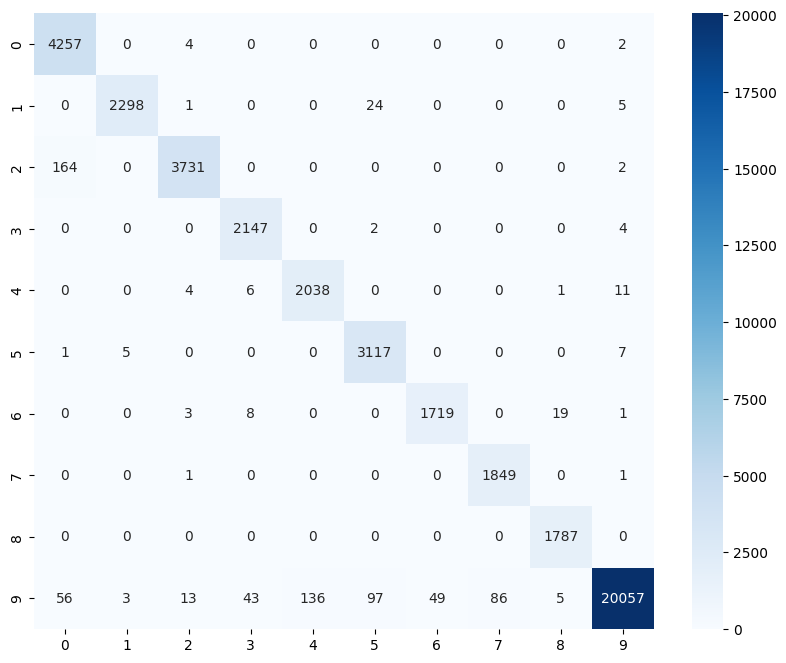

In [14]:
# num_features = len(list_of_dataframes[0].columns) - 1
# Define LSTM model
model = Sequential([
    LSTM(units=64, input_shape=(window_size, num_features), return_sequences=True, activation='tanh'),
    BatchNormalization(),
    LSTM(units=64, return_sequences=False, activation='tanh'),
    Dropout(0.5),
    BatchNormalization(),
    Dense(units=64, activation='tanh'),
    BatchNormalization(),
    Dense(units=number_classes, activation='softmax')
])

# [ 0 0 0 0 1]
# [ 0 0 0 1 0 ]
# Compile the model
# adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile( optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])
# model.compile(optimizer=)
# change optimizer
# model.compile(optimizer='', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train_one_hot, epochs=5, batch_size=500, validation_split=0.1)#, use_multiprocessing=True, workers=4)

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test_one_hot)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

# Save the model
model.save('./models/lstm_model.keras')

# Display model summary
# model.summary()

# get the classification report
# from sklearn.metrics import classification_report
# print(classification_report(y_true, y_pred))
# get the accuracy

from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get the predicted class for each sample
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1) # Convert one-hot encoded labels back to a single label
print("len of y_pred", len(y_pred))
print(y_pred)

# Get the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)





In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get the predicted class for each sample
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1) # Convert one-hot encoded labels back to a single label
print("len of y_pred", len(y_pred))
print(y_pred)

# Get the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)

In [ ]:
import math
# Model parameters

n_features = 105  
n_timesteps = 20

def create_lstm_model():

    model = Sequential()
    model.add(LSTM(64, activation='tanh', return_sequences=True, input_shape=(n_timesteps, 104)))
    
    model.add(LSTM(64, activation='tanh')) # Add a second LSTM layer

    # dense layer 
    model.add(Dense(units=128, activation='relu'))
    model.add(Dense(1, activation='softmax')) # Output layer
    # model.compile(loss='sarse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

# Create model  
lstm_model = create_lstm_model()

# Loop through dataframes
# take only the 100-105 rows of data
for i, sample in enumerate(list_of_dataframes):
    # normalize the dataframe 
    # normalize  the dataframe
    normalzed_df = sample.copy()
    # for feature_name in sample.columns:
    #     if feature_name != 'label':
    #         max_value = sample[feature_name].max()
    #         min_value = sample[feature_name].min()
    #         normalzed_df[feature_name] = (sample[feature_name] - min_value) / (max_value - min_value)

    sample = normalzed_df
    # sample = (sample - sample.mean()) / (sample.max() - sample.min())
    # Preprocess data
    # truncated_data = sample[:50] 
    # print("truncated_data: ", truncated_data.shape)
    # X = truncated_data.dop('label', axis=1).values
    # X = X.reshape(X.shape[0], n_timesteps,  int(X.shape[1]/n_timesteps))
    # y = truncated_data['label']
    # print("x shape: ", X.shape)
    scaler = StandardScaler()
    # scaled_data = scaler.fit_transform(sample)
    # sample = pd.DataFrame(scaled_data, columns=sample.columns)
    
    # Get input data
    X = sample.drop('label', axis=1).values

    # scaler.fit(X)
    # scaled_x = pd.DataFrame(scaler.transform(X), columns=sample.columns[:-1])
    # X = scaled_x.values
    num_samples = X.shape[0]
    print("num_samples: ", num_samples)

    # Calculate number of complete timesteps
    num_complete_timesteps = math.floor(num_samples / n_timesteps)
    print("num_complete_timesteps: ", num_complete_timesteps)
    print("num features: ", X.shape[1])

    # Drop any leftover samples
    sample = sample[:num_complete_timesteps * n_timesteps]
    # X = X[:num_complete_timesteps * n_timesteps]

    # # Reshape 
    # X = X.reshape(num_complete_timesteps, n_timesteps, n_features)
    # y = sample['label'][:num_complete_timesteps * n_timesteps]
    # print("x shape after: ", X.shape)
    # # reshape y 
    # y = y.values.reshape(num_complete_timesteps, n_timesteps, 1)
    # print("y shape after: ", y.shape)

    print("label: ", sample['label'].head(1))

    df = sample.drop('label', axis=1)
    #print the label 
    df = df.values.reshape(num_complete_timesteps, n_timesteps, n_features)
    # One-hot encode target data 
    # gestures = ['wave', 'clap', 'punch']
    # y = np.zeros((len(y), len(gestures)))
    # for i, gesture in enumerate(y):
    #     y[i, gestures.index(gesture)] = 1 

    # Now split into X and y
    X = df[:, :, :-1] 
    y = df[:, -1, -1]
    print("x shape after: ", X.shape)
    print("y shape after: ", y.shape)

# Split data into train/test
    # X_train, X_test, y_train, y_test = train_test_split(X, y)
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train model 
    lstm_model.fit(X_train, y_train, epochs=2, batch_size=10, validation_data=(X_test, y_test))

    # Evaluate model
    loss, accuracy = lstm_model.evaluate(X_test, y_test)
    print(f'Accuracy for DF {i}: {accuracy*100:.2f}%')

    # run a prediction on the model

    print("running a prediction on the model")
    prediction = lstm_model.predict(X_test)
    print("prediction: ", prediction)